In [ ]:
# install packages

# !pip install bs4
# !pip install contractions
# !pip install wordninja
# !pip install spellchecker
# !pip install nltk
# !pip install spacy
# !pip install deep_translator
# !pip install tqdm
# !pip install langdetect
# !pip install gensim
# !pip install contractions
# !pip install pycld2 
# !pip install dask
# !pip install pyLDAvis


In [303]:
#import libraries

import pandas as pd
from pandas.core.common import flatten
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,  TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
from gensim.models import CoherenceModel
from itertools import chain
# import spacy
from string import punctuation
from deep_translator import GoogleTranslator
import unicodedata
import contractions
from langdetect import detect
import time
import gensim
from gensim import corpora
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw')
nltk.download('averaged_perceptron_tagger')

!python -m spacy download en_core_web_sm
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /home/jupyter/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


     |████████████████████████████████| 13.9 MB 463 kB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Data Pre-processing -- Skip this step -- Download preprocessed data here:
https://drive.google.com/file/d/1Ppgcqob9UYaoaWJrw_mSC49IV9W4eHDt/view?usp=sharing

In [ ]:
#Import data using pandas
df = pd.read_csv('task-8-dataset-120212021.csv', encoding='utf-8')

In [ ]:
#language detection
def detect_my(text):
   try:
       return detect(text)
   except:
       return 'unknown'

df['language'] = df['content'].apply(detect_my)

In [ ]:
#This function prepares text data for translation (data cleaning part 1)

def content_cleaning(content):
    text = re.sub(r"http\S+", "", str(content))                    #remove url
    text = text.encode('ascii', 'ignore').decode('utf-8')     #remove emojis
    text = text.replace('\xa0', ' ')                          #remove non-utf characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')    #remove accented characters
    text = re.sub(r'[＃#](\w+)', ' ', text)                   #remove hashtags
    text = re.sub(r'[0-9]', ' ', text)                        #remove numerics
    text = BeautifulSoup(text, 'html.parser').get_text()   #remove html tags
    
    return text

In [ ]:
df['text_clean'] = df['content'].apply(lambda x: content_cleaning(x))

In [ ]:
#Text translation

def split_paragraphs(doc):
    if len(doc) > 5000:
        return re.split(r'\n{1,}', doc.strip())
    else:
        return tokenize.sent_tokenize(doc)


#Translating to english
def trans_char(text):
    try:
        translated = GoogleTranslator(source='auto', target='en').translate(text)
        if translated is None:
            translated = text
        return translated
    except:
        return 'Unable to Translate'
  
    
def translate_text_en(text):
    translated_para = []
    if isinstance(text, str):
        translated_string = trans_char(text)
        time.sleep(2)
        return translated_string
    elif isinstance(text, list):
        for paragraph in text:
            if len(paragraph) > 1:
                translated = trans_char(paragraph)
                translated_para.append(translated)
            else: 
                translated_para.append(paragraph)
                time.sleep(2)
        return translated_para
    

#Returning back to doc
def join_translated_paragraphs(doc):
    if isinstance(doc, str):
        return doc
    elif isinstance(doc, list):
        return '\n'.join(doc)


def text_translation(clean_text):
    split_text = split_paragraphs(clean_text)
    trans_text = translate_text_en(split_text)
    trans_doc = join_translated_paragraphs(trans_text)
    return trans_doc

In [ ]:
#Create a subset for non-english texts to be translated
lang_exclude = ['en', 'unknown']

df_non_en = df[~df['language'].isin(lang_exclude)]

In [ ]:
df_non_en['text_clean'] = df_non_en['text_clean'].progress_apply(lambda x: text_translation(x))

In [ ]:
#Filter english texts
df_en = df[df['language'] == 'en']

#Concat english and non-english texts
final_df = pd.concat([df_en, df_non_en], ignore_index=True)

### Please start here: Download preprocessed data here:
https://drive.google.com/file/d/1Ppgcqob9UYaoaWJrw_mSC49IV9W4eHDt/view?usp=sharing

In [346]:
# import dill
dill.load_session('notebook_env.db')

In [304]:
final_df = pd.read_csv('final_df_translated.csv')

In [305]:
#Part 2 of Data Cleaning Process
#This function converts parts of speech tags to wordnet’s format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [306]:
#This function further preprocess data to prepare for modeling

stop = stopwords.words('english')
stop.extend(['akin', 'natin', 'wala', 'pala', 'well', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ni', 'nila', 'nilang', 'nito', 'niya', 'niyang', 'noon', 'o', 'pa', 'paano', 'pababa', 'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'palabas', 'pamamagitan', 'panahon', 'pangalawa', 'para', 'paraan', 'pareho', 'pataas', 'pero', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi', 'sabihin', 'sarili', 'sila', 'sino', 'siya', 'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang', 'ba', 'eh', 'kasi', 'lang', 'mo', 'naman', 'opo', 'po', 'si', 'talaga', 'yung'])
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def text_preprocessing(doc):
    clean_text = str(doc).lower()      #Lowercase
    clean_text = contractions.fix(clean_text)     #fixes contractions
    clean_text = re.sub(r'\n{1,}', ' ', clean_text)     #remove newline characters
    clean_text = re.sub(r'[^\w\s]', '',clean_text)      #remove punctuations
    clean_text = re.sub(' +', ' ', clean_text)          #remove extra whitespace
    clean_text = re.sub(r'(^|\s)press release.*?clickbacktrue($|\s)', ' ',clean_text)  #remove Senate News Intro
    clean_text = ' '.join([word for word in clean_text.split() if word not in (stop)])  #removes stopwords
    clean_text = re.sub(r'\b(\w{1,3})\b', '', clean_text)
    tokenized_text = w_tokenizer.tokenize(clean_text)      #tokenizes text
    pos_tag_text = nltk.tag.pos_tag(tokenized_text)  #pos tagging text
    wordnet_pos = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in pos_tag_text]   #converts pos to wordnet format
    lemmatized_text = [lemmatizer.lemmatize(word, tag) for word, tag in wordnet_pos]      #lemmatizes text
    return lemmatized_text

In [307]:
final_df['lemma_text'] = final_df['text_clean'].progress_apply(lambda x: str(text_preprocessing(x)))

  0%|          | 0/199507 [00:00<?, ?it/s]

In [308]:
final_df['lemma_text_unlist'] = final_df.lemma_text.astype(str).str.replace('\[|\]|\'|\,', '')

In [ ]:
#Feature Extraction
final_df['word_count'] = final_df['content'].str.split().str.len()
final_df['char_count'] = final_df['content'].str.len()

In [ ]:
#Word count distribution
sns.distplot(final_df['word_count'], color="r")

In [ ]:
#Character count distribution
sns.distplot(final_df['char_count'], color="r")

In [ ]:
#Source frequency
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
ax = sns.countplot(x='source', data=final_df, order = final_df['source'].value_counts().index)

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=90)
ax = sns.countplot(x='candidate', data=final_df, order = final_df['candidate'].value_counts().index)

In [ ]:
#Sentiment Analysis
sid = SentimentIntensityAnalyzer()

final_df['sid_score'] = final_df['text_clean'].progress_apply(lambda x: sid.polarity_scores(str(x)))

In [ ]:
final_df['sid_compound'] = final_df['sid_score'].progress_apply(lambda score_dict: score_dict['compound'])
# df_en.head(20)

In [ ]:
final_df.to_csv('final_df_sentiment.csv')

In [ ]:
def sentiment_score(sid):
    if sid >= 0.5:
        return 'Positive'
    elif sid >= -0.5 and sid <= 0.5:
        return 'Neutral'
    else:
        return 'Negative'

final_df['sentiment'] = final_df['sid_compound'].apply(lambda x: sentiment_score(x))

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=90)
ax = sns.countplot(x='sentiment', data=final_df, order = final_df['sentiment'].value_counts().index)

### Checkpoint: Identifying Bigrams and Trigrams

In [309]:
#Identifying bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([content.split() for content in final_df.lemma_text_unlist])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(100)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [310]:
#Identifying Trigrams
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([content.split() for content in final_df.lemma_text_unlist])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(100)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)
# trigram_scores

In [311]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
# bigram_pmi

In [312]:
trigram_pmi.to_csv('trigrams.csv')

In [313]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
# trigram_pmi

In [314]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [315]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [316]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [317]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [318]:
final_df['lemma_ngram'] = final_df['lemma_text_unlist'].map(lambda x: replace_ngram(x))
# df_en['lemma_ngram']

In [368]:
#Filter for only nouns¶
#Nouns are most likely indicators of a topic. For example, for the sentence ‘The store is nice’, we know the sentence is talking about ‘store’. The other words in the sentence provide more context and explanation about the topic (‘store’) itself. Therefore, filtering for the noun cleans the text for words that are more interpretable in the topic model.

# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [320]:
final_df['lemma_noun'] = final_df['lemma_ngram'].apply(lambda row: nltk.word_tokenize(row))
final_df = final_df['lemma_noun'].map(noun_only)

### Topic Modeling - Presidential Candidate

In [376]:
pres = ['Antonio Parlade Jr.', 'Ferdinand Marcos Jr.', 'Francisco Moreno Domagoso', 'Leni Robredo', 'Leody de Guzman', 'Manny Pacquiao', 'Norberto B. Gonzales', 'Panfilo Lacson']

In [378]:
def get_candidate_data(pres_list, df=final_df):
  df_list = {}
  for candidate in pres_list:
    candidate_df = final_df[final_df.candidate == candidate]
    candidate_df = candidate_df.reset_index(drop=True)
    df_list[candidate] = candidate_df
  return df_list

In [385]:
candidate_data = get_candidate_data(pres)

parlade_df = candidate_data['Antonio Parlade Jr.'].lemma_noun.map(noun_only)
marcos_df = candidate_data['Ferdinand Marcos Jr.'].lemma_noun.map(noun_only)
moreno_df = candidate_data['Francisco Moreno Domagoso'].lemma_noun.map(noun_only)
robredo_df = candidate_data['Leni Robredo'].lemma_noun.map(noun_only)
deguzman_df = candidate_data['Leody de Guzman'].lemma_noun.map(noun_only)
pacquiao_df = candidate_data['Manny Pacquiao'].lemma_noun.map(noun_only)
gonzales_df = candidate_data['Norberto B. Gonzales'].lemma_noun.map(noun_only)
lacson_df = candidate_data['Panfilo Lacson'].lemma_noun.map(noun_only)

In [380]:
def create_dict_corpus(texts):
  dictionary = corpora.Dictionary(texts)
  dictionary.filter_extremes(no_below=5, no_above=0.5)
  corpus = [dictionary.doc2bow(text) for text in texts]
  return dictionary, corpus

In [390]:
parlade_dict, parlade_corpus = create_dict_corpus(parlade_df)
marcos_dict, marcos_corpus = create_dict_corpus(marcos_df)
moreno_dict, moreno_corpus = create_dict_corpus(moreno_df)
robredo_dict, robredo_corpus = create_dict_corpus(robredo_df)
deguzman_dict, deguzman_corpus = create_dict_corpus(deguzman_df)
pacquiao_dict, pacquiao_corpus = create_dict_corpus(pacquiao_df)
gonzales_dict, gonzales_corpus = create_dict_corpus(gonzales_df)
lacson_dict, lacson_corpus = create_dict_corpus(lacson_df)

In [404]:
Lda = gensim.models.ldamodel.LdaModel


def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus, num_topics=num_topics, id2word=dictionary, passes=40, iterations=500,  chunksize =500, eval_every=None, random_state=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [408]:
# Can take a long time to run.

parlade_model_list, parlade_coherence_values = compute_coherence_values(dictionary=parlade_dict, corpus=parlade_corpus, texts=parlade_df, start=3, limit=10, step=1)
marcos_model_list, marcos_coherence_values = compute_coherence_values(dictionary=marcos_dict, corpus=marcos_corpus, texts=marcos_df, start=3, limit=10, step=1)
moreno_model_list, moreno_coherence_values = compute_coherence_values(dictionary=moreno_dict, corpus=moreno_corpus, texts=moreno_df, start=3, limit=10, step=1)
robredo_model_list, robredo_coherence_values = compute_coherence_values(dictionary=robredo_dict, corpus=robredo_corpus, texts=robredo_df, start=3, limit=10, step=1)
deguzman_model_list, deguzman_coherence_values = compute_coherence_values(dictionary=deguzman_dict, corpus=deguzman_corpus, texts=deguzman_df, start=3, limit=10, step=1)
pacquiao_model_list, pacquiao_coherence_values = compute_coherence_values(dictionary=pacquiao_dict, corpus=pacquiao_corpus, texts=pacquiao_df, start=3, limit=10, step=1)
gonzales_model_list, gonzales_coherence_values = compute_coherence_values(dictionary=gonzales_dict, corpus=gonzales_corpus, texts=gonzales_df, start=3, limit=10, step=1)
lacson_model_list, lacson_coherence_values = compute_coherence_values(dictionary=lacson_dict, corpus=lacson_corpus, texts=lacson_df, start=3, limit=10, step=1)

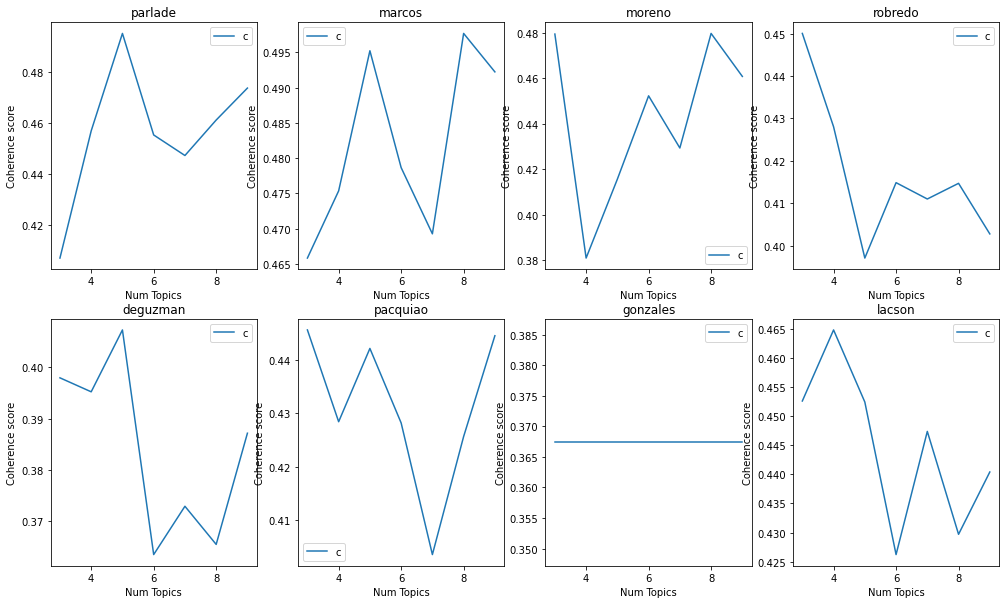

In [410]:
limit=10; start=3; step=1;

pres_names = ['parlade', 'marcos', 'moreno', 'robredo', 'deguzman', 'pacquiao', 'gonzales', 'lacson']
pres_coherence_scores = [parlade_coherence_values, marcos_coherence_values, moreno_coherence_values, robredo_coherence_values, 
                         deguzman_coherence_values, pacquiao_coherence_values, gonzales_coherence_values, lacson_coherence_values]

num_topics = range(start, limit, step)

plt.rcParams['figure.figsize'] = [17, 10]

for i in range(len(pres_names)):
  plt.subplot(2, 4, i+1)
  plt.plot(num_topics, pres_coherence_scores[i])
  plt.xlabel("Num Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')
  plt.title(pres_names[i])
plt.show()

In [411]:
parlade_best_model = parlade_model_list[2]
marcos_best_model = marcos_model_list[2]
moreno_best_model = moreno_model_list[3]
robredo_best_model = robredo_model_list[3]
deguzman_best_model = deguzman_model_list[2]
pacquiao_best_model = pacquiao_model_list[2]
gonzales_best_model = gonzales_model_list[0]
lacson_best_model = lacson_model_list[1]

In [416]:
# import pickle
import pickle

def save_model(model, model_name):
  pickle.dump(model, open(f"lda_models/{model_name}.pkl", "wb"))

def load_model(model_name):
  model = pickle.load(open(f"lda_models/{model_name}.pkl", "rb"))
  return model

In [417]:
candidate_best_models = [parlade_best_model, marcos_best_model, moreno_best_model, robredo_best_model, deguzman_best_model, pacquiao_best_model, gonzales_best_model, lacson_best_model]
pres_candidate_models = dict(zip(pres_names, candidate_best_models))

for candidate_name, candidate_model in pres_candidate_models.items():
  save_model(candidate_model, candidate_name)

In [418]:
candidate_models = []
pres_names = ['parlade', 'marcos', 'moreno', 'robredo', 'deguzman', 'pacquiao', 'gonzales', 'lacson']

for candidate_name in pres_names:
  candidate_model = load_model(candidate_name)
  candidate_models.append(candidate_model)
candidate_models

In [419]:
def display_topics(model):
  topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=15)] for n in range(0, model.num_topics)]
  
  # set column width
  pd.set_option('display.max_colwidth', -1)
  topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Words per Topic'], index=['Topic_'+str(t) for t in range(1, model.num_topics+1)] )
  return topics_df

In [420]:
parlade_df_topic = display_topics(parlade_best_model)
marcos_df_topic = display_topics(marcos_best_model)
moreno_df_topic = display_topics(moreno_best_model)
robredo_df_topic = display_topics(robredo_best_model)
deguzman_df_topic = display_topics(deguzman_best_model)
pacquiao_df_topic = display_topics(pacquiao_best_model)
gonzales_df_topic = display_topics(gonzales_best_model)
lacson_df_topic = display_topics(lacson_best_model)

In [421]:
def display_wordcloud(df_topic, rows, cols, fig_size):

  # initiate wordcloud object
  wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

  # set the figure size
  plt.rcParams['figure.figsize'] = fig_size

  # Create subplots for each topic
  for i in range(df_topic.shape[0]):

      wc.generate(text=df_topic["Words per Topic"][i])
      
      plt.subplot(rows, cols, i+1)
      plt.imshow(wc, interpolation="bilinear")
      plt.axis("off")
      plt.title(df_topic.index[i])

  plt.show()

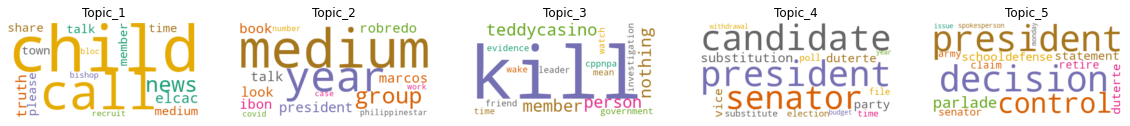

In [422]:
display_wordcloud(parlade_df_topic, 1, 5, [20,10])

In [423]:
parlade_model = load_model('parlade')
marcos_model = load_model('marcos')
moreno_model = load_model('moreno')
robredo_model = load_model('robredo')
deguzman_model = load_model('deguzman')
pacquiao_model = load_model('pacquiao')
gonzales_model = load_model('gonzales')
lacson_model = load_model('lacson')

In [425]:
parlade_viz = gensimvis.prepare(parlade_model, parlade_corpus, parlade_dict)
marcos_viz = gensimvis.prepare(marcos_model, marcos_corpus, marcos_dict)
moreno_viz = gensimvis.prepare(moreno_model, moreno_corpus, moreno_dict)
robredo_viz = gensimvis.prepare(robredo_model, robredo_corpus, robredo_dict)
deguzman_viz = gensimvis.prepare(deguzman_model, deguzman_corpus, deguzman_dict)
pacquiao_viz = gensimvis.prepare(pacquiao_model, pacquiao_corpus, pacquiao_dict)
gonzales_viz = gensimvis.prepare(gonzales_model, gonzales_corpus, gonzales_dict)
lacson_viz = gensimvis.prepare(lacson_model, lacson_corpus, lacson_dict)

In [427]:
parlade_html = pyLDAvis.prepared_data_to_html(parlade_viz)
marcos_html = pyLDAvis.prepared_data_to_html(marcos_viz)
moreno_html = pyLDAvis.prepared_data_to_html(moreno_viz)
robredo_html = pyLDAvis.prepared_data_to_html(robredo_viz)
deguzman_html = pyLDAvis.prepared_data_to_html(deguzman_viz)
pacquiao_html = pyLDAvis.prepared_data_to_html(pacquiao_viz)
gonzales_html = pyLDAvis.prepared_data_to_html(gonzales_viz)
lacson_html = pyLDAvis.prepared_data_to_html(lacson_viz)

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

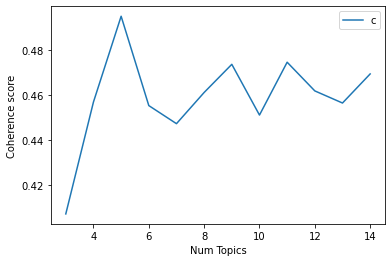

In [393]:
# Show graph
limit=15; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [394]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4071
Num Topics = 4  has Coherence Value of 0.4568
Num Topics = 5  has Coherence Value of 0.4949
Num Topics = 6  has Coherence Value of 0.4552
Num Topics = 7  has Coherence Value of 0.4472
Num Topics = 8  has Coherence Value of 0.461
Num Topics = 9  has Coherence Value of 0.4735
Num Topics = 10  has Coherence Value of 0.451
Num Topics = 11  has Coherence Value of 0.4745
Num Topics = 12  has Coherence Value of 0.4617
Num Topics = 13  has Coherence Value of 0.4563
Num Topics = 14  has Coherence Value of 0.4693


In [399]:
from pprint import pprint
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.020*"child" + 0.020*"member" + 0.018*"school" + 0.016*"medium" + '
  '0.015*"year" + 0.014*"kill" + 0.014*"talk" + 0.013*"call" + 0.013*"time" + '
  '0.012*"news" + 0.012*"elcac" + 0.011*"work" + 0.011*"philippinestar" + '
  '0.011*"book" + 0.010*"ibon" + 0.010*"government" + 0.010*"teddycasino" + '
  '0.010*"story" + 0.009*"share" + 0.009*"quismorio"'),
 (1,
  '0.045*"president" + 0.025*"candidate" + 0.022*"senator" + 0.019*"vice" + '
  '0.017*"election" + 0.017*"duterte" + 0.016*"substitution" + 0.015*"party" + '
  '0.011*"substitute" + 0.009*"file" + 0.009*"marcos" + 0.008*"year" + '
  '0.008*"poll" + 0.008*"group" + 0.007*"medium" + 0.007*"robredo" + '
  '0.007*"member" + 0.006*"candidacy" + 0.006*"withdrawal" + 0.006*"talk"'),
 (2,
  '0.036*"president" + 0.029*"decision" + 0.023*"parlade" + 0.020*"control" + '
  '0.015*"statement" + 0.015*"duterte" + 0.014*"defense" + 0.012*"senator" + '
  '0.011*"time" + 0.011*"retire" + 0.010*"claim" + 0.009*"army" + '
  '0.009*"govern

In [400]:
topic_data =  gensimvis.prepare(optimal_model, parlade_corpus, parlade_dict, mds = 'pcoa')
pyLDAvis.display(topic_data)

### Topic Modeling - Antonio Parlade Jr.

In [321]:
final_df_parlade = final_df[final_df['candidate'] == 'Antonio Parlade Jr.']
final_df_parlade.shape

(581, 13)

In [323]:
dictionary = corpora.Dictionary(final_content_parlade)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000)

In [324]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_content_parlade]

In [325]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel_parlade = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=40,\
               iterations=500,  chunksize = 500, eval_every = None, random_state=123)

In [326]:
ldamodel_parlade.show_topics(10, num_words=10, formatted=False)

[(0,
  [('talk', 0.086339),
   ('medium', 0.05973419),
   ('please', 0.047367025),
   ('truth', 0.047044247),
   ('share', 0.046797708),
   ('news', 0.038129944),
   ('town', 0.03744464),
   ('bishop', 0.037035007),
   ('forum', 0.036681253),
   ('part', 0.031428307)]),
 (1,
  [('president', 0.066369206),
   ('senator', 0.037404824),
   ('vice', 0.036652558),
   ('candidate', 0.027037643),
   ('substitute', 0.020253707),
   ('covid', 0.016010897),
   ('robredo', 0.013931733),
   ('file', 0.013901603),
   ('member', 0.013291593),
   ('election', 0.012736936)]),
 (2,
  [('teddycasino', 0.041710965),
   ('kill', 0.036523372),
   ('nothing', 0.033330526),
   ('time', 0.025951225),
   ('watch', 0.0226642),
   ('cppnpa', 0.018919714),
   ('church', 0.017844247),
   ('anything', 0.016081253),
   ('evidence', 0.015388836),
   ('person', 0.015024235)]),
 (3,
  [('government', 0.049136337),
   ('budget', 0.04121606),
   ('bloc', 0.030306457),
   ('challenge', 0.021331422),
   ('fund', 0.02024212

In [327]:
topic_data =  gensimvis.prepare(ldamodel_parlade, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

In [ ]:
pyLDAvis.save_html(topic_data, 'lda_parlade.html')

In [328]:
#Getting coherence score --
#Coherence measures the relative distance between words within a topic. It is good for assessing the quality of the learned topics. So the higher the score is, the better the topics are extracted.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda_parlade = CoherenceModel(model=ldamodel_parlade, texts=final_content_parlade, dictionary=dictionary, coherence='c_v')
coherence_lda_parlade = coherence_model_lda_parlade.get_coherence()
print('\nCoherence Score: ', coherence_lda_parlade)


Coherence Score:  0.45099234047541736


### How to find the optimal number of topics for LDA? - Antonio Parlade Jr.

In [335]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=15, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus, num_topics=num_topics, id2word = dictionary, passes=40, iterations=500,  chunksize = 500, eval_every = None, random_state=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [336]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=final_content_parlade, start=3, limit=15, step=1)

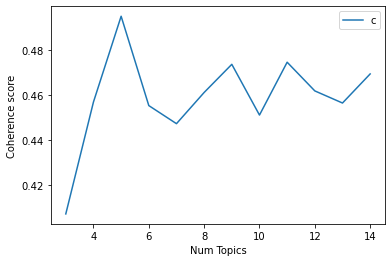

In [337]:
# Show graph
limit=15; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [338]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4071
Num Topics = 4  has Coherence Value of 0.4568
Num Topics = 5  has Coherence Value of 0.4949
Num Topics = 6  has Coherence Value of 0.4552
Num Topics = 7  has Coherence Value of 0.4472
Num Topics = 8  has Coherence Value of 0.461
Num Topics = 9  has Coherence Value of 0.4735
Num Topics = 10  has Coherence Value of 0.451
Num Topics = 11  has Coherence Value of 0.4745
Num Topics = 12  has Coherence Value of 0.4617
Num Topics = 13  has Coherence Value of 0.4563
Num Topics = 14  has Coherence Value of 0.4693


In [339]:
from pprint import pprint

In [341]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.045*"child" + 0.027*"call" + 0.023*"news" + 0.021*"elcac" + 0.019*"truth" '
  '+ 0.019*"medium" + 0.019*"share" + 0.018*"please" + 0.018*"member" + '
  '0.017*"time" + 0.017*"talk" + 0.015*"town" + 0.015*"bishop" + '
  '0.014*"recruit" + 0.013*"bloc" + 0.013*"parent" + 0.012*"viber" + '
  '0.012*"challenge" + 0.012*"story" + 0.012*"sent"'),
 (1,
  '0.022*"medium" + 0.019*"year" + 0.018*"group" + 0.018*"president" + '
  '0.016*"robredo" + 0.014*"look" + 0.014*"talk" + 0.013*"marcos" + '
  '0.013*"book" + 0.012*"ibon" + 0.011*"philippinestar" + 0.011*"work" + '
  '0.010*"case" + 0.010*"number" + 0.010*"covid" + 0.010*"rice" + '
  '0.010*"support" + 0.009*"accord" + 0.009*"show" + 0.009*"vice"'),
 (2,
  '0.033*"kill" + 0.027*"teddycasino" + 0.024*"member" + 0.022*"nothing" + '
  '0.018*"person" + 0.016*"government" + 0.015*"watch" + 0.014*"time" + '
  '0.012*"cppnpa" + 0.010*"evidence" + 0.010*"leader" + 0.010*"investigation" '
  '+ 0.010*"mean" + 0.009*"wake" + 0.009*"friend" +

In [342]:
topic_data =  gensimvis.prepare(optimal_model, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

In [344]:
# import dill
dill.dump_session('notebook_env.db')

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

### Topic Modeling - Ferdinand Marcos Jr.

In [ ]:
final_df_marcos = final_df[final_df['candidate'] == 'Ferdinand Marcos Jr.']
final_df_marcos.shape

In [ ]:
final_content_marcos = final_df_marcos['lemma_noun'].map(noun_only)

In [ ]:
dictionary = corpora.Dictionary(final_content_marcos)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_content_marcos]

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel_marcos = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=123)

In [ ]:
ldamodel_marcos.show_topics(3, num_words=10, formatted=False)

In [ ]:
topic_data =  gensimvis.prepare(ldamodel_marcos, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

In [ ]:
pyLDAvis.save_html(topic_data, 'lda_marcos.html')

In [ ]:
#Getting coherence score --
#Coherence measures the relative distance between words within a topic. It is good for assessing the quality of the learned topics. So the higher the score is, the better the topics are extracted.

coherence_model_lda_marcos = CoherenceModel(model=ldamodel_marcos, texts=final_content_marcos, dictionary=dictionary, coherence='c_v')
coherence_lda_marcos = coherence_model_lda_marcos.get_coherence()
print('\nCoherence Score: ', coherence_lda_parlade)

### Optimize Number of Topics - Ferdinand Marcos Jr.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=15, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus, num_topics=num_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=final_content_marcos, start=3, limit=15, step=1)

In [ ]:
# Show graph
limit=15; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

In [ ]:
topic_data =  gensimvis.prepare(optimal_model, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

### Topic Modeling - Francisco Moreno Domagoso

In [ ]:
final_df_moreno = final_df[final_df['candidate'] == 'Francisco Moreno Domagoso']
final_df_moreno.shape

In [ ]:
final_content_moreno = final_df_moreno['lemma_noun'].map(noun_only)

In [ ]:
dictionary = corpora.Dictionary(final_content_moreno)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_content_moreno]

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel_moreno = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 100, eval_every = None, random_state=123)

In [ ]:
ldamodel_moreno.show_topics(10, num_words=10, formatted=False)

In [ ]:
topic_data =  gensimvis.prepare(ldamodel_moreno, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

In [ ]:
pyLDAvis.save_html(topic_data, 'lda_moreno.html')

In [ ]:
#Getting coherence score --
#Coherence measures the relative distance between words within a topic. It is good for assessing the quality of the learned topics. So the higher the score is, the better the topics are extracted.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda_moreno = CoherenceModel(model=ldamodel_moreno, texts=final_content_moreno, dictionary=dictionary, coherence='c_v')
coherence_lda_moreno = coherence_model_lda_moreno.get_coherence()
print('\nCoherence Score: ', coherence_lda_moreno)

### Optimize Number of Topics - Francisco Moreno Domagoso

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=15, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus, num_topics=num_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=final_content_moreno, start=3, limit=15, step=1)


# Show graph
limit=15; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

### Dominant topic and its percentage contribution in each document

In [ ]:
def format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=content):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=content)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [ ]:
# Show
df_dominant_topic.head(20)

### The most representative sentence for each topic

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(20)

In [ ]:
sent_topics_sorteddf.to_excel('topic_content_example.xlsx')

### Frequency Distribution of Word Counts in Documents

In [ ]:
doc_lens = [len(d) for d in final_df.content]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 5000, color='navy')
plt.text(3750, 15000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(3750, 13000, "Median : " + str(round(np.median(doc_lens))))
plt.text(3750, 11000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(3750, 9000, "1st Percentile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(3750, 7000, "99th Percentile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 5000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,5000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

### Word Clouds of Top N Keywords in Each Topic

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(5, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
### Checkpoint
# !pip install dill
# import dill
# dill.dump_session('notebook_env.db')
dill.load_session('notebook_env.db')

In [ ]:
### Checkpoint
# !pip install dill
# import dill
# dill.dump_session('notebook_env.db')
# dill.load_session('notebook_env.db')

In [ ]:
topic_words = lda_model

### Cosine Similarity b/w Documents

In [ ]:
### Given a keyword, Document Recommender system can suggest you the best documents from the pool of documents.
words_list=list(chain.from_iterable(final_content))

In [ ]:
title = [x for x in final_df['content']]

In [ ]:
# Cosine similarity
def cosine_sim(text1, text2):
    tfidf_score = TfidfVectorizer().fit_transform([text1, text2])
    return ((tfidf_score * tfidf_score.T).A)[0, 1]

# Most similar article
def closest_doc_name(sentence, docs):
    cos = []
    for i in range(len(docs)):
        cos.append(cosine_sim(', '.join(sentence.split(' ')),', '.join(docs[i])))
    return [title[x] for x in np.argsort(cos)[-20:][::-1]]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer().fit(words_list)

In [ ]:
closest_doc_name('corruption', final_content)

In [ ]:
### Checkpoint
# !pip install dill
# import dill
dill.dump_session('notebook_env.db')
# dill.load_session('notebook_env.db')

In [ ]:
import dill

In [ ]:
dill.dump_session('notebook_env.db')

In [ ]:
final_df_export.to_excel('final_data.xlsx')

In [ ]:
import openpyxl

In [ ]:
!pip install openpyxl